In [1]:
import numpy as np
import pandas as pd

from random import randint
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.color import gray2rgb
from skimage.morphology import label

from keras.preprocessing.image import load_img
from keras.models import model_from_json
from keras import Model
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam, SGD, Nadam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization,UpSampling2D,Concatenate
from tqdm import tqdm_notebook
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
import json
import gc
from keras.preprocessing import image

Using TensorFlow backend.


# Params and helpers

In [2]:
use_rotate = False
use_zoom = False
use_slice = False
use_brightness = False
use_normalize = False
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
img_size_ori = 101
img_size_patch = 256
img_size_target = 256

def sq_up_resize(img):
    if len(img.shape)==2 or img.shape[2]==1:
        new_img = np.zeros((img.shape[0]*2,img.shape[1]*2))
    else:
        new_img = np.zeros((img.shape[0]*2,img.shape[1]*2, img.shape[2]))
    
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if len(img.shape)==2  or img.shape[2]==1:
                new_img[y*2:y*2+2,x*2:x*2+2] = img[y,x]
            else:
                new_img[y*2:y*2+2,x*2:x*2+2,0] = img[y,x,0]
                new_img[y*2:y*2+2,x*2:x*2+2,1] = img[y,x,1]
                new_img[y*2:y*2+2,x*2:x*2+2,2] = img[y,x,2]
    return new_img

def sq_down_resize(img):
    if len(img.shape)==2 or img.shape[2]==1:
        new_img = np.zeros((img.shape[0]//2,img.shape[1]//2))
    else:
        new_img = np.zeros((img.shape[0]//2,img.shape[1]//2,img.shape[2]))
        
    for y in range(new_img.shape[0]):
        for x in range(new_img.shape[1]):
            if len(img.shape)==2  or img.shape[2]==1:
                new_img[y,x] = img[y*2,x*2]
            else:
                new_img[y,x,0] = img[y*2,x*2,0]
                new_img[y,x,1] = img[y*2,x*2,1]
                new_img[y,x,2] = img[y*2,x*2,2]
    return new_img

def upsample_padd_mirror(img):
    resize_img = sq_up_resize(img)#, (202, 202))#, interp='nearest')
    #resize_img = resize(img,(202, 202), mode='reflect',preserve_range=True,anti_aliasing=False)
    padding_img = np.pad(resize_img,27,mode='reflect')
    del resize_img
    gc.collect()
    return padding_img

def make_orgsize_padd_mirror(img):
    crop  = img[27:202+27,27:202+27]
    resize_img = sq_down_resize(crop)
    #resize_img = resize(crop,(101,101),mode='reflect',preserve_range=True,anti_aliasing=False)
    return resize_img

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
def downpatchsize(img):
    return resize(img, (img_size_patch, img_size_patch), mode='constant', preserve_range=True)

def uporgsize(img):
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

ni = upsample_padd_mirror(train_df["images"][5])
nm = upsample_padd_mirror(train_df["masks"][5])
plt.imshow(ni,cmap='gray')
plt.imshow(nm,cmap='Greens',alpha=0.3)
plt.show()

rei = make_orgsize_padd_mirror(ni)
rem = make_orgsize_padd_mirror(nm)
plt.imshow(rei,cmap='gray')
plt.imshow(rem,cmap='Greens',alpha=0.3)
plt.show()

oi = train_df["images"][5]
om = train_df["masks"][5]
plt.imshow(oi,cmap='gray')
plt.imshow(om,cmap='Greens',alpha=0.3)
plt.show()
print(oi[0:2,0:2])
print(rei[0:2,0:2])

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def RLenc(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def keras_lovasz_hinge(labels,logits):
    return lovasz_hinge(logits, labels, per_image=True, ignore=None)

def focal_loss(y_true, y_pred):
    gamma=0.5
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


def bce_dice_lovasz_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) + lovasz_loss(y_true, y_pred)

def bce_dice_loss_non_empty(y_true, y_pred):
    return K.max(K.max(y_true,axis=0),axis=1)*(binary_crossentropy(y_true, y_pred)-K.log(1. - dice_loss(y_true, y_pred)))
    #is_non_empty = K.max(K.max(y_true,axis=0),axis=1)
    #wbdce_loss = weighted_bce_dice_loss(y_true,y_pred)
    #return wbdce_loss*is_non_empty
    
def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)


# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [4]:
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [5]:
reload_train_set = False
mean_use = False
train_df_upsample_file_name = "train_df_mirror_padding.pkl"
if reload_train_set == True:
    train_df["images"] = [upsample_padd_mirror(np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255) for idx in tqdm_notebook(train_df.index)]
    mean_im = np.mean(train_df["images"])
    if mean_use == True:
        train_df["images"] = train_df["images"] - mean_im
    train_df["masks"] = [upsample_padd_mirror(np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255) for idx in tqdm_notebook(train_df.index)]
    train_df["bin_class"] =  [np.max(train_df.masks[idx]) for idx in tqdm_notebook(train_df.index)]
    train_df["rle_mask"] = [RLenc(train_df.masks[idx]) for idx in tqdm_notebook(train_df.index)]
    train_df.to_pickle(train_df_upsample_file_name)
else:
    train_df = pd.read_pickle(train_df_upsample_file_name)

In [6]:
train_df["bin_class"] =  [np.max(train_df.masks[idx]) for idx in tqdm_notebook(train_df.index)]

## Test Set Load

In [7]:
reload_test_set = False
test_set_npy_file_name = "test_set.npy"
if reload_test_set == True:
    if mean_use == True:
        x_test = [upsample_padd_mirror(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))/255 -mean_im) for idx in tqdm_notebook(test_df.index)]
    else:
        x_test = [upsample_padd_mirror(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))/255) for idx in tqdm_notebook(test_df.index)]
    np.save(test_set_npy_file_name,x_test)    
else:
    x_test = np.load(test_set_npy_file_name)

In [8]:
x_test_z = np.array([test_df.z[idx] for idx in tqdm_notebook(test_df.index)])

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [9]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(train_df.masks[0].shape[0], 2)

In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

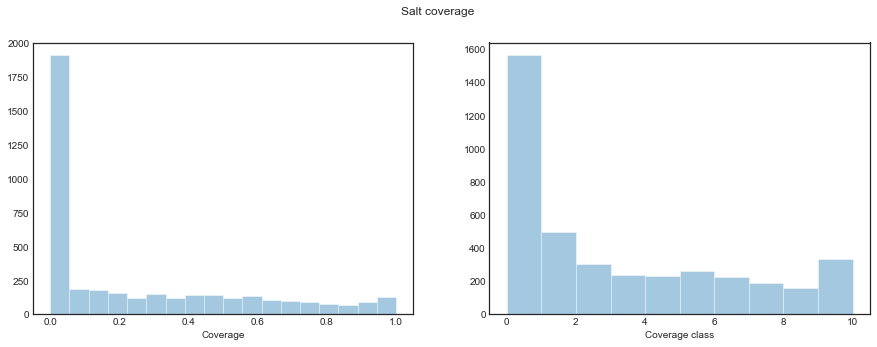

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Depth channel add or convert 3channel

In [12]:
depth_use = False

z_mean = train_df.z.mean()
train_df_add_z_image = train_df

if depth_use == True:
    train_df_add_z_image.images =  [ np.stack([train_df.images[idx],train_df.images[idx], np.zeros((img_size_target,img_size_target)) + (train_df.z[idx])/1000],axis=2) for idx in tqdm_notebook(train_df.index)]
    x_test_add_z_image =  [ np.stack([x_test[idx].squeeze(),x_test[idx].squeeze(), np.zeros((img_size_target,img_size_target)) + (x_test_z[idx])/1000],axis=2) for idx in tqdm_notebook(range(test_df.shape[0]))]
else:
    train_df_add_z_image.images =  [ np.stack([train_df.images[idx],train_df.images[idx],train_df.images[idx] ],axis=2) for idx in tqdm_notebook(train_df.index)]
    x_test_add_z_image =  [ np.stack([x_test[idx].squeeze(),x_test[idx].squeeze(), x_test[idx].squeeze()],axis=2) for idx in tqdm_notebook(range(test_df.shape[0]))]

## Generator

In [13]:
from segmentation_models import Unet#, FPN
from segmentation_models import Linknet,PSPNet
from segmentation_models.unet_hyper_bin.model import Unet_hyper_bin
from segmentation_models.fpn_hyper_bin.model import FPN_hyper_bin
from segmentation_models.linknet_hyper_bin.model import Linknet_hyper_bin
from segmentation_models.utils import set_trainable, recompile

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [14]:
back_bones = []
back_bones.append({"back_bone":"resnet50","weight":"imagenet11k-places365ch"})
back_bones.append({"back_bone":"resnet152","weight":"imagenet11k"})
back_bones.append({"back_bone":"densenet121","weight":"imagenet"})
back_bones.append({"back_bone":"densenet169","weight":"imagenet"})
back_bones.append({"back_bone":"densenet201","weight":"imagenet"})
back_bones.append({"back_bone":"inceptionresnetv2","weight":"imagenet"})
back_bones.append({"back_bone":"inceptionv3","weight":"imagenet"})
back_bones.append({"back_bone":"resnet101","weight":"imagenet"})
back_bones.append({"back_bone":"resnet152","weight":"imagenet"})
back_bones.append({"back_bone":"resnet18","weight":"imagenet"})
back_bones.append({"back_bone":"resnet34","weight":"imagenet"})
back_bones.append({"back_bone":"resnet50","weight":"imagenet"})
back_bones.append({"back_bone":"resnext101","weight":"imagenet"})
back_bones.append({"back_bone":"resnext50","weight":"imagenet"})
back_bones.append({"back_bone":"vgg19","weight":"imagenet"})
back_bones.append({"back_bone":"vgg16","weight":"imagenet"})

rands_states = [1111,2222,3333,4444,5555,6666,8888,9999,9876]
archs = ["UnetHB_SPDR","Unet","Linknet","PSPNet","FPN"]

In [15]:
backbone_weight = 'imagenet'
backbone_name = 'resnet152'
arch = "UnetHB_SPDR_BINMUL_SE_MULTI"
rand_state= 9800
BATCH_SIZE = 8
batch_size = BATCH_SIZE
model_name = arch + '_pad_with_weirdmask_bcedice_'+ 'bb_' + backbone_name + '_bw_'+ backbone_weight +'_ts_' + str(img_size_target) + '_ps_'+str(img_size_patch) + '_bs_' + str(BATCH_SIZE) 
model_name += '_sprs_' + str(rand_state) + '_du_' + str(depth_use)+ '_mu_' + str(mean_use)

input_img_ch = 3
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test, bin_class_train, bin_class_valid = train_test_split(
    train_df_add_z_image.index.values,
    np.array(train_df_add_z_image.images.tolist()).reshape(-1, img_size_target, img_size_target, input_img_ch), 
    np.array(train_df_add_z_image.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df_add_z_image.coverage.values,
    train_df_add_z_image.z.values,
    train_df_add_z_image.bin_class.values,
    test_size=0.2, stratify=train_df_add_z_image.coverage_class, random_state=rand_state)

In [16]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
bin_class_train = np.append(bin_class_train,bin_class_train)
print(x_train.shape)
print(y_valid.shape)
print(bin_class_train.shape)

(6400, 256, 256, 3)
(800, 256, 256, 1)
(6400,)


In [17]:
if arch == 'FPN_D4_SE_BIN':
    model = FPN_hyper_bin(input_shape=(img_size_patch,img_size_patch,input_img_ch), backbone_name=backbone_name,encoder_weights=backbone_weight)
elif arch == "Unet":
    model = Unet(input_shape=(img_size_patch,img_size_patch,input_img_ch), backbone_name=backbone_name, encoder_weights=backbone_weight)
elif arch == "Linknet_hyper3_bin":
    model = Linknet_hyper_bin(input_shape=(img_size_patch,img_size_patch,input_img_ch), backbone_name=backbone_name, encoder_weights=backbone_weight)
elif arch == "PSPNet":
    model = PSPNet(input_shape=(img_size_patch,img_size_patch,input_img_ch), backbone_name=backbone_name, encoder_weights=backbone_weight,activation='sigmoid', classes=1)
elif arch == "UnetHB_SPDR_BINMUL_SE_MULTI":
    model = Unet_hyper_bin(input_shape=(img_size_patch,img_size_patch,input_img_ch), backbone_name=backbone_name, encoder_weights=backbone_weight)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

__________________________________________________________________________________________________
stage2_unit4_conv1 (Conv2D)     (None, 32, 32, 128)  65536       stage2_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_bn2 (BatchNormaliz (None, 32, 32, 128)  512         stage2_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu2 (Activation) (None, 32, 32, 128)  0           stage2_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 34, 34, 128)  0           stage2_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit4_conv2 (Conv2D)     (None, 32, 32, 128)  147456      zero_padding2d_9[0][0]           
__________

stage3_unit3_conv1 (Conv2D)     (None, 16, 16, 256)  262144      stage3_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_bn2 (BatchNormaliz (None, 16, 16, 256)  1024        stage3_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_relu2 (Activation) (None, 16, 16, 256)  0           stage3_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 18, 18, 256)  0           stage3_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit3_conv2 (Conv2D)     (None, 16, 16, 256)  589824      zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
stage3_uni

__________________________________________________________________________________________________
stage3_unit10_relu2 (Activation (None, 16, 16, 256)  0           stage3_unit10_bn2[0][0]          
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 18, 18, 256)  0           stage3_unit10_relu2[0][0]        
__________________________________________________________________________________________________
stage3_unit10_conv2 (Conv2D)    (None, 16, 16, 256)  589824      zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
stage3_unit10_bn3 (BatchNormali (None, 16, 16, 256)  1024        stage3_unit10_conv2[0][0]        
__________________________________________________________________________________________________
stage3_unit10_relu3 (Activation (None, 16, 16, 256)  0           stage3_unit10_bn3[0][0]          
__________

zero_padding2d_30 (ZeroPadding2 (None, 18, 18, 256)  0           stage3_unit17_relu2[0][0]        
__________________________________________________________________________________________________
stage3_unit17_conv2 (Conv2D)    (None, 16, 16, 256)  589824      zero_padding2d_30[0][0]          
__________________________________________________________________________________________________
stage3_unit17_bn3 (BatchNormali (None, 16, 16, 256)  1024        stage3_unit17_conv2[0][0]        
__________________________________________________________________________________________________
stage3_unit17_relu3 (Activation (None, 16, 16, 256)  0           stage3_unit17_bn3[0][0]          
__________________________________________________________________________________________________
stage3_unit17_conv3 (Conv2D)    (None, 16, 16, 1024) 262144      stage3_unit17_relu3[0][0]        
__________________________________________________________________________________________________
add_28 (Ad

__________________________________________________________________________________________________
stage3_unit24_bn3 (BatchNormali (None, 16, 16, 256)  1024        stage3_unit24_conv2[0][0]        
__________________________________________________________________________________________________
stage3_unit24_relu3 (Activation (None, 16, 16, 256)  0           stage3_unit24_bn3[0][0]          
__________________________________________________________________________________________________
stage3_unit24_conv3 (Conv2D)    (None, 16, 16, 1024) 262144      stage3_unit24_relu3[0][0]        
__________________________________________________________________________________________________
add_35 (Add)                    (None, 16, 16, 1024) 0           stage3_unit24_conv3[0][0]        
                                                                 add_34[0][0]                     
__________________________________________________________________________________________________
stage3_uni

stage3_unit31_relu3 (Activation (None, 16, 16, 256)  0           stage3_unit31_bn3[0][0]          
__________________________________________________________________________________________________
stage3_unit31_conv3 (Conv2D)    (None, 16, 16, 1024) 262144      stage3_unit31_relu3[0][0]        
__________________________________________________________________________________________________
add_42 (Add)                    (None, 16, 16, 1024) 0           stage3_unit31_conv3[0][0]        
                                                                 add_41[0][0]                     
__________________________________________________________________________________________________
stage3_unit32_bn1 (BatchNormali (None, 16, 16, 1024) 4096        add_42[0][0]                     
__________________________________________________________________________________________________
stage3_unit32_relu1 (Activation (None, 16, 16, 1024) 0           stage3_unit32_bn1[0][0]          
__________

__________________________________________________________________________________________________
stage4_unit2_conv3 (Conv2D)     (None, 8, 8, 2048)   1048576     stage4_unit2_relu3[0][0]         
__________________________________________________________________________________________________
add_49 (Add)                    (None, 8, 8, 2048)   0           stage4_unit2_conv3[0][0]         
                                                                 add_48[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_bn1 (BatchNormaliz (None, 8, 8, 2048)   8192        add_49[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_relu1 (Activation) (None, 8, 8, 2048)   0           stage4_unit3_bn1[0][0]           
__________________________________________________________________________________________________
stage4_uni

                                                                 dense_16[0][0]                   
__________________________________________________________________________________________________
decoder_stage2_conv2 (Conv2D)   (None, 64, 64, 64)   36864       multiply_8[0][0]                 
__________________________________________________________________________________________________
decoder_stage2_bn2 (BatchNormal (None, 64, 64, 64)   256         decoder_stage2_conv2[0][0]       
__________________________________________________________________________________________________
decoder_stage2_relu2 (Activatio (None, 64, 64, 64)   0           decoder_stage2_bn2[0][0]         
__________________________________________________________________________________________________
global_average_pooling2d_10 (Gl (None, 64)           0           decoder_stage2_relu2[0][0]       
__________________________________________________________________________________________________
reshape_9 

# Training

In [19]:
best_model_save_path = './model/'+ model_name + '.h5'
best_model_config_path = './model/'+ model_name + '.json'
model_config = model.to_json()

In [20]:
with open(best_model_config_path, 'w') as outfile:
    json.dump(model_config, outfile)

In [21]:
callbacks1 = [EarlyStopping(monitor='val_fusion_my_iou_metric',
                           patience=10,
                           verbose=1,
                           min_delta=0.00001,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_fusion_my_iou_metric',
                               factor=0.2,
                               patience=5,
                               verbose=1,
                               min_delta=0.00001,
                               mode='max'),
             ModelCheckpoint(monitor='val_fusion_my_iou_metric',
                             filepath= best_model_save_path,
                             save_best_only=True,
                             save_weights_only = True,
                             mode='max') ,
             TQDMNotebookCallback()           
             ]
callbacks2 = [EarlyStopping(monitor='val_fusion_my_iou_metric',
                           patience=20,
                           verbose=1,
                           min_delta=0.00001,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_my_iou_metric',
                               factor=0.5,
                               patience=8,
                               verbose=1,
                               min_delta=0.00001,
                               mode='max'),
             ModelCheckpoint(monitor='val_my_iou_metric',
                             filepath= best_model_save_path,
                             save_best_only=True,
                             save_weights_only = True,
                             mode='max') ,
             TQDMNotebookCallback()           
             ]

In [22]:
opt = Adam(lr = 0.0001)
#early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=10, verbose=1)
#model_checkpoint = ModelCheckpoint(best_model_save_path,monitor='my_iou_metric', mode = 'max', save_best_only=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
#tqdm_nb = TQDMNotebookCallback() 

losses = [binary_crossentropy,bce_dice_loss_non_empty,weighted_bce_dice_loss]

lossWeights = [0.05,0.1,1.0]
y_tt = [bin_class_train,y_train,y_train]
y_vv = [bin_class_valid,y_valid,y_valid]
mertrics1 = {'fusion':my_iou_metric}
#opt = SGD(lr = 0.01, momentum=0.9, decay=0.0001)
#model.compile(loss=weighted_bce_dice_loss, optimizer=opt, metrics=[my_iou_metric])
#model.compile(loss=weighted_bce_dice_loss, optimizer=opt, metrics=[my_iou_metric])
#outputs = model.outputs
#deep_model = Model(inputs=model.inputs, outputs=outputs)
model.compile(optimizer=opt, loss=losses ,loss_weights=lossWeights, metrics=mertrics1)

set_trainable(model)
history1 = model.fit(x_train, y_tt,
                    validation_data=[x_valid, y_vv], 
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks1, 
                    verbose=2)

model.load_weights(best_model_save_path)
history2 = model.fit(x_train, y_tt,
                    validation_data=[x_valid, y_vv], 
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks2, 
                    verbose=2)

Train on 6400 samples, validate on 800 samples


Epoch 1/50


 - 444s - loss: 1.9655 - classification_loss: 0.3558 - hypercolumn_loss: 0.5911 - fusion_loss: 1.0187 - fusion_my_iou_metric: 0.4361 - val_loss: 1.5721 - val_classification_loss: 0.2565 - val_hypercolumn_loss: 0.4453 - val_fusion_loss: 0.8703 - val_fusion_my_iou_metric: 0.5655
Epoch 2/50


 - 392s - loss: 1.4581 - classification_loss: 0.2775 - hypercolumn_loss: 0.4018 - fusion_loss: 0.7789 - fusion_my_iou_metric: 0.6515 - val_loss: 1.4312 - val_classification_loss: 0.3036 - val_hypercolumn_loss: 0.4101 - val_fusion_loss: 0.7175 - val_fusion_my_iou_metric: 0.6832
Epoch 3/50


 - 392s - loss: 1.2591 - classification_loss: 0.2835 - hypercolumn_loss: 0.3395 - fusion_loss: 0.6361 - fusion_my_iou_metric: 0.6952 - val_loss: 1.1002 - val_classification_loss: 0.2820 - val_hypercolumn_loss: 0.2825 - val_fusion_loss: 0.5358 - val_fusion_my_iou_metric: 0.7648
Epoch 4/50


 - 392s - loss: 1.1418 - classification_loss: 0.2713 - hypercolumn_loss: 0.3123 - fusion_loss: 0.5583 - fusion_my_iou_metric: 0.7214 - val_loss: 1.0329 - val_classification_loss: 0.2492 - val_hypercolumn_loss: 0.3026 - val_fusion_loss: 0.4811 - val_fusion_my_iou_metric: 0.7880
Epoch 5/50


 - 393s - loss: 0.9660 - classification_loss: 0.2408 - hypercolumn_loss: 0.2551 - fusion_loss: 0.4700 - fusion_my_iou_metric: 0.7656 - val_loss: 1.0216 - val_classification_loss: 0.2790 - val_hypercolumn_loss: 0.3161 - val_fusion_loss: 0.4265 - val_fusion_my_iou_metric: 0.7789
Epoch 6/50


 - 393s - loss: 0.8917 - classification_loss: 0.2298 - hypercolumn_loss: 0.2335 - fusion_loss: 0.4283 - fusion_my_iou_metric: 0.7742 - val_loss: 1.1405 - val_classification_loss: 0.2840 - val_hypercolumn_loss: 0.3539 - val_fusion_loss: 0.5026 - val_fusion_my_iou_metric: 0.7324
Epoch 7/50


 - 391s - loss: 0.8450 - classification_loss: 0.2174 - hypercolumn_loss: 0.2185 - fusion_loss: 0.4091 - fusion_my_iou_metric: 0.7872 - val_loss: 1.2895 - val_classification_loss: 0.3430 - val_hypercolumn_loss: 0.4112 - val_fusion_loss: 0.5353 - val_fusion_my_iou_metric: 0.7535
Epoch 8/50


 - 393s - loss: 0.7874 - classification_loss: 0.2045 - hypercolumn_loss: 0.2071 - fusion_loss: 0.3758 - fusion_my_iou_metric: 0.7974 - val_loss: 1.0884 - val_classification_loss: 0.3134 - val_hypercolumn_loss: 0.3330 - val_fusion_loss: 0.4421 - val_fusion_my_iou_metric: 0.7495
Epoch 9/50


 - 393s - loss: 0.7567 - classification_loss: 0.2047 - hypercolumn_loss: 0.1909 - fusion_loss: 0.3611 - fusion_my_iou_metric: 0.8047 - val_loss: 0.8618 - val_classification_loss: 0.2204 - val_hypercolumn_loss: 0.2779 - val_fusion_loss: 0.3635 - val_fusion_my_iou_metric: 0.7782

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 10/50


 - 394s - loss: 0.5713 - classification_loss: 0.1470 - hypercolumn_loss: 0.1332 - fusion_loss: 0.2911 - fusion_my_iou_metric: 0.8537 - val_loss: 0.8683 - val_classification_loss: 0.2204 - val_hypercolumn_loss: 0.2880 - val_fusion_loss: 0.3598 - val_fusion_my_iou_metric: 0.8134
Epoch 11/50


 - 393s - loss: 0.5185 - classification_loss: 0.1312 - hypercolumn_loss: 0.1127 - fusion_loss: 0.2745 - fusion_my_iou_metric: 0.8646 - val_loss: 0.8584 - val_classification_loss: 0.2145 - val_hypercolumn_loss: 0.2806 - val_fusion_loss: 0.3634 - val_fusion_my_iou_metric: 0.8186
Epoch 12/50


 - 393s - loss: 0.4615 - classification_loss: 0.1151 - hypercolumn_loss: 0.0955 - fusion_loss: 0.2509 - fusion_my_iou_metric: 0.8764 - val_loss: 0.8984 - val_classification_loss: 0.2256 - val_hypercolumn_loss: 0.3116 - val_fusion_loss: 0.3611 - val_fusion_my_iou_metric: 0.8150
Epoch 13/50


 - 396s - loss: 0.4271 - classification_loss: 0.1054 - hypercolumn_loss: 0.0858 - fusion_loss: 0.2359 - fusion_my_iou_metric: 0.8821 - val_loss: 0.9681 - val_classification_loss: 0.2441 - val_hypercolumn_loss: 0.3534 - val_fusion_loss: 0.3705 - val_fusion_my_iou_metric: 0.8183
Epoch 14/50


 - 393s - loss: 0.4088 - classification_loss: 0.0999 - hypercolumn_loss: 0.0795 - fusion_loss: 0.2295 - fusion_my_iou_metric: 0.8878 - val_loss: 0.9206 - val_classification_loss: 0.2253 - val_hypercolumn_loss: 0.3264 - val_fusion_loss: 0.3689 - val_fusion_my_iou_metric: 0.8226
Epoch 15/50


 - 392s - loss: 0.3810 - classification_loss: 0.0922 - hypercolumn_loss: 0.0738 - fusion_loss: 0.2151 - fusion_my_iou_metric: 0.8923 - val_loss: 0.8745 - val_classification_loss: 0.2449 - val_hypercolumn_loss: 0.2866 - val_fusion_loss: 0.3429 - val_fusion_my_iou_metric: 0.8224
Epoch 16/50


 - 393s - loss: 0.3610 - classification_loss: 0.0873 - hypercolumn_loss: 0.0675 - fusion_loss: 0.2062 - fusion_my_iou_metric: 0.8966 - val_loss: 0.9212 - val_classification_loss: 0.2344 - val_hypercolumn_loss: 0.3340 - val_fusion_loss: 0.3527 - val_fusion_my_iou_metric: 0.8271
Epoch 17/50


 - 391s - loss: 0.3461 - classification_loss: 0.0848 - hypercolumn_loss: 0.0646 - fusion_loss: 0.1967 - fusion_my_iou_metric: 0.8996 - val_loss: 0.9058 - val_classification_loss: 0.2290 - val_hypercolumn_loss: 0.3186 - val_fusion_loss: 0.3582 - val_fusion_my_iou_metric: 0.8178
Epoch 18/50


 - 392s - loss: 0.3324 - classification_loss: 0.0823 - hypercolumn_loss: 0.0591 - fusion_loss: 0.1909 - fusion_my_iou_metric: 0.9035 - val_loss: 0.9857 - val_classification_loss: 0.2458 - val_hypercolumn_loss: 0.3569 - val_fusion_loss: 0.3831 - val_fusion_my_iou_metric: 0.8185
Epoch 19/50


 - 392s - loss: 0.3144 - classification_loss: 0.0779 - hypercolumn_loss: 0.0543 - fusion_loss: 0.1823 - fusion_my_iou_metric: 0.9075 - val_loss: 0.9421 - val_classification_loss: 0.2359 - val_hypercolumn_loss: 0.3455 - val_fusion_loss: 0.3607 - val_fusion_my_iou_metric: 0.8242
Epoch 20/50


 - 391s - loss: 0.2993 - classification_loss: 0.0747 - hypercolumn_loss: 0.0512 - fusion_loss: 0.1734 - fusion_my_iou_metric: 0.9116 - val_loss: 0.9435 - val_classification_loss: 0.2331 - val_hypercolumn_loss: 0.3405 - val_fusion_loss: 0.3699 - val_fusion_my_iou_metric: 0.8292
Epoch 21/50


 - 392s - loss: 0.2812 - classification_loss: 0.0719 - hypercolumn_loss: 0.0469 - fusion_loss: 0.1623 - fusion_my_iou_metric: 0.9155 - val_loss: 0.9687 - val_classification_loss: 0.2376 - val_hypercolumn_loss: 0.3581 - val_fusion_loss: 0.3730 - val_fusion_my_iou_metric: 0.8231
Epoch 22/50


 - 390s - loss: 0.2895 - classification_loss: 0.0768 - hypercolumn_loss: 0.0482 - fusion_loss: 0.1645 - fusion_my_iou_metric: 0.9147 - val_loss: 0.9728 - val_classification_loss: 0.2480 - val_hypercolumn_loss: 0.3620 - val_fusion_loss: 0.3628 - val_fusion_my_iou_metric: 0.8225
Epoch 23/50


 - 392s - loss: 0.2663 - classification_loss: 0.0704 - hypercolumn_loss: 0.0435 - fusion_loss: 0.1524 - fusion_my_iou_metric: 0.9205 - val_loss: 0.9884 - val_classification_loss: 0.2482 - val_hypercolumn_loss: 0.3598 - val_fusion_loss: 0.3805 - val_fusion_my_iou_metric: 0.8214
Epoch 24/50


 - 392s - loss: 0.2591 - classification_loss: 0.0667 - hypercolumn_loss: 0.0442 - fusion_loss: 0.1482 - fusion_my_iou_metric: 0.9209 - val_loss: 1.0368 - val_classification_loss: 0.2481 - val_hypercolumn_loss: 0.3912 - val_fusion_loss: 0.3975 - val_fusion_my_iou_metric: 0.8257
Epoch 25/50


 - 392s - loss: 0.2422 - classification_loss: 0.0652 - hypercolumn_loss: 0.0388 - fusion_loss: 0.1381 - fusion_my_iou_metric: 0.9239 - val_loss: 0.9973 - val_classification_loss: 0.2483 - val_hypercolumn_loss: 0.3636 - val_fusion_loss: 0.3854 - val_fusion_my_iou_metric: 0.8247

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 26/50


 - 392s - loss: 0.2240 - classification_loss: 0.0617 - hypercolumn_loss: 0.0350 - fusion_loss: 0.1272 - fusion_my_iou_metric: 0.9299 - val_loss: 0.9940 - val_classification_loss: 0.2463 - val_hypercolumn_loss: 0.3647 - val_fusion_loss: 0.3829 - val_fusion_my_iou_metric: 0.8275
Epoch 27/50


 - 392s - loss: 0.2187 - classification_loss: 0.0632 - hypercolumn_loss: 0.0333 - fusion_loss: 0.1222 - fusion_my_iou_metric: 0.9319 - val_loss: 1.0156 - val_classification_loss: 0.2531 - val_hypercolumn_loss: 0.3695 - val_fusion_loss: 0.3929 - val_fusion_my_iou_metric: 0.8249
Epoch 28/50


 - 392s - loss: 0.2126 - classification_loss: 0.0615 - hypercolumn_loss: 0.0318 - fusion_loss: 0.1193 - fusion_my_iou_metric: 0.9331 - val_loss: 1.0147 - val_classification_loss: 0.2488 - val_hypercolumn_loss: 0.3707 - val_fusion_loss: 0.3953 - val_fusion_my_iou_metric: 0.8260
Epoch 29/50


 - 395s - loss: 0.2176 - classification_loss: 0.0617 - hypercolumn_loss: 0.0334 - fusion_loss: 0.1226 - fusion_my_iou_metric: 0.9333 - val_loss: 0.9975 - val_classification_loss: 0.2524 - val_hypercolumn_loss: 0.3600 - val_fusion_loss: 0.3852 - val_fusion_my_iou_metric: 0.8279
Epoch 30/50


 - 393s - loss: 0.2248 - classification_loss: 0.0652 - hypercolumn_loss: 0.0345 - fusion_loss: 0.1252 - fusion_my_iou_metric: 0.9346 - val_loss: 1.0090 - val_classification_loss: 0.2484 - val_hypercolumn_loss: 0.3626 - val_fusion_loss: 0.3980 - val_fusion_my_iou_metric: 0.8267

Epoch 00030: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
Epoch 00030: early stopping

Train on 6400 samples, validate on 800 samples


Epoch 1/50


 - 392s - loss: 0.2807 - classification_loss: 0.0756 - hypercolumn_loss: 0.0460 - fusion_loss: 0.1590 - fusion_my_iou_metric: 0.9163 - val_loss: 0.9326 - val_classification_loss: 0.2320 - val_hypercolumn_loss: 0.3375 - val_fusion_loss: 0.3631 - val_fusion_my_iou_metric: 0.8284


C:\Anaconda3\envs\py36\lib\site-packages\keras\callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_my_iou_metric` which is not available. Available metrics are: val_loss,val_classification_loss,val_hypercolumn_loss,val_fusion_loss,val_fusion_my_iou_metric,loss,classification_loss,hypercolumn_loss,fusion_loss,fusion_my_iou_metric,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Anaconda3\envs\py36\lib\site-packages\keras\callbacks.py:432: RuntimeWarning: Can save best model only with val_my_iou_metric available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/50


 - 395s - loss: 0.2719 - classification_loss: 0.0713 - hypercolumn_loss: 0.0443 - fusion_loss: 0.1564 - fusion_my_iou_metric: 0.9195 - val_loss: 0.9294 - val_classification_loss: 0.2321 - val_hypercolumn_loss: 0.3346 - val_fusion_loss: 0.3628 - val_fusion_my_iou_metric: 0.8239
Epoch 3/50


 - 392s - loss: 0.2689 - classification_loss: 0.0717 - hypercolumn_loss: 0.0436 - fusion_loss: 0.1536 - fusion_my_iou_metric: 0.9200 - val_loss: 0.9414 - val_classification_loss: 0.2334 - val_hypercolumn_loss: 0.3392 - val_fusion_loss: 0.3687 - val_fusion_my_iou_metric: 0.8254
Epoch 4/50


 - 392s - loss: 0.2676 - classification_loss: 0.0724 - hypercolumn_loss: 0.0434 - fusion_loss: 0.1518 - fusion_my_iou_metric: 0.9192 - val_loss: 0.9412 - val_classification_loss: 0.2321 - val_hypercolumn_loss: 0.3384 - val_fusion_loss: 0.3706 - val_fusion_my_iou_metric: 0.8246
Epoch 5/50


 - 393s - loss: 0.2663 - classification_loss: 0.0709 - hypercolumn_loss: 0.0427 - fusion_loss: 0.1527 - fusion_my_iou_metric: 0.9205 - val_loss: 0.9414 - val_classification_loss: 0.2340 - val_hypercolumn_loss: 0.3380 - val_fusion_loss: 0.3694 - val_fusion_my_iou_metric: 0.8241
Epoch 6/50


 - 391s - loss: 0.2693 - classification_loss: 0.0757 - hypercolumn_loss: 0.0416 - fusion_loss: 0.1519 - fusion_my_iou_metric: 0.9205 - val_loss: 0.9519 - val_classification_loss: 0.2314 - val_hypercolumn_loss: 0.3469 - val_fusion_loss: 0.3736 - val_fusion_my_iou_metric: 0.8257
Epoch 7/50


 - 391s - loss: 0.2794 - classification_loss: 0.0814 - hypercolumn_loss: 0.0425 - fusion_loss: 0.1555 - fusion_my_iou_metric: 0.9199 - val_loss: 0.9540 - val_classification_loss: 0.2305 - val_hypercolumn_loss: 0.3486 - val_fusion_loss: 0.3748 - val_fusion_my_iou_metric: 0.8256
Epoch 8/50


 - 392s - loss: 0.2624 - classification_loss: 0.0715 - hypercolumn_loss: 0.0408 - fusion_loss: 0.1501 - fusion_my_iou_metric: 0.9216 - val_loss: 0.9481 - val_classification_loss: 0.2330 - val_hypercolumn_loss: 0.3422 - val_fusion_loss: 0.3729 - val_fusion_my_iou_metric: 0.8227
Epoch 9/50


 - 394s - loss: 0.2665 - classification_loss: 0.0774 - hypercolumn_loss: 0.0402 - fusion_loss: 0.1489 - fusion_my_iou_metric: 0.9210 - val_loss: 0.9478 - val_classification_loss: 0.2332 - val_hypercolumn_loss: 0.3414 - val_fusion_loss: 0.3732 - val_fusion_my_iou_metric: 0.8237
Epoch 10/50


 - 393s - loss: 0.2602 - classification_loss: 0.0708 - hypercolumn_loss: 0.0406 - fusion_loss: 0.1489 - fusion_my_iou_metric: 0.9232 - val_loss: 0.9581 - val_classification_loss: 0.2322 - val_hypercolumn_loss: 0.3504 - val_fusion_loss: 0.3754 - val_fusion_my_iou_metric: 0.8246
Epoch 11/50


 - 391s - loss: 0.2615 - classification_loss: 0.0704 - hypercolumn_loss: 0.0419 - fusion_loss: 0.1492 - fusion_my_iou_metric: 0.9222 - val_loss: 0.9594 - val_classification_loss: 0.2334 - val_hypercolumn_loss: 0.3501 - val_fusion_loss: 0.3759 - val_fusion_my_iou_metric: 0.8239
Epoch 12/50


 - 393s - loss: 0.2626 - classification_loss: 0.0715 - hypercolumn_loss: 0.0420 - fusion_loss: 0.1492 - fusion_my_iou_metric: 0.9230 - val_loss: 0.9657 - val_classification_loss: 0.2332 - val_hypercolumn_loss: 0.3529 - val_fusion_loss: 0.3796 - val_fusion_my_iou_metric: 0.8234
Epoch 13/50


 - 395s - loss: 0.2638 - classification_loss: 0.0757 - hypercolumn_loss: 0.0399 - fusion_loss: 0.1482 - fusion_my_iou_metric: 0.9216 - val_loss: 0.9701 - val_classification_loss: 0.2318 - val_hypercolumn_loss: 0.3550 - val_fusion_loss: 0.3833 - val_fusion_my_iou_metric: 0.8229
Epoch 14/50


 - 394s - loss: 0.2706 - classification_loss: 0.0788 - hypercolumn_loss: 0.0418 - fusion_loss: 0.1500 - fusion_my_iou_metric: 0.9224 - val_loss: 0.9682 - val_classification_loss: 0.2337 - val_hypercolumn_loss: 0.3548 - val_fusion_loss: 0.3796 - val_fusion_my_iou_metric: 0.8220
Epoch 15/50


 - 395s - loss: 0.2580 - classification_loss: 0.0732 - hypercolumn_loss: 0.0390 - fusion_loss: 0.1457 - fusion_my_iou_metric: 0.9242 - val_loss: 0.9765 - val_classification_loss: 0.2338 - val_hypercolumn_loss: 0.3579 - val_fusion_loss: 0.3848 - val_fusion_my_iou_metric: 0.8225
Epoch 16/50


 - 394s - loss: 0.2719 - classification_loss: 0.0813 - hypercolumn_loss: 0.0403 - fusion_loss: 0.1504 - fusion_my_iou_metric: 0.9222 - val_loss: 0.9866 - val_classification_loss: 0.2343 - val_hypercolumn_loss: 0.3646 - val_fusion_loss: 0.3878 - val_fusion_my_iou_metric: 0.8204
Epoch 17/50


 - 393s - loss: 0.2630 - classification_loss: 0.0747 - hypercolumn_loss: 0.0395 - fusion_loss: 0.1487 - fusion_my_iou_metric: 0.9232 - val_loss: 0.9795 - val_classification_loss: 0.2337 - val_hypercolumn_loss: 0.3604 - val_fusion_loss: 0.3854 - val_fusion_my_iou_metric: 0.8256
Epoch 18/50


 - 394s - loss: 0.2505 - classification_loss: 0.0696 - hypercolumn_loss: 0.0387 - fusion_loss: 0.1423 - fusion_my_iou_metric: 0.9247 - val_loss: 0.9786 - val_classification_loss: 0.2336 - val_hypercolumn_loss: 0.3593 - val_fusion_loss: 0.3857 - val_fusion_my_iou_metric: 0.8202
Epoch 19/50


 - 392s - loss: 0.2618 - classification_loss: 0.0757 - hypercolumn_loss: 0.0394 - fusion_loss: 0.1468 - fusion_my_iou_metric: 0.9241 - val_loss: 0.9839 - val_classification_loss: 0.2328 - val_hypercolumn_loss: 0.3648 - val_fusion_loss: 0.3863 - val_fusion_my_iou_metric: 0.8229
Epoch 20/50


 - 393s - loss: 0.2534 - classification_loss: 0.0703 - hypercolumn_loss: 0.0388 - fusion_loss: 0.1442 - fusion_my_iou_metric: 0.9248 - val_loss: 0.9856 - val_classification_loss: 0.2330 - val_hypercolumn_loss: 0.3657 - val_fusion_loss: 0.3870 - val_fusion_my_iou_metric: 0.8245
Epoch 21/50


 - 392s - loss: 0.2556 - classification_loss: 0.0698 - hypercolumn_loss: 0.0400 - fusion_loss: 0.1457 - fusion_my_iou_metric: 0.9242 - val_loss: 0.9903 - val_classification_loss: 0.2349 - val_hypercolumn_loss: 0.3665 - val_fusion_loss: 0.3888 - val_fusion_my_iou_metric: 0.8217
Epoch 00021: early stopping



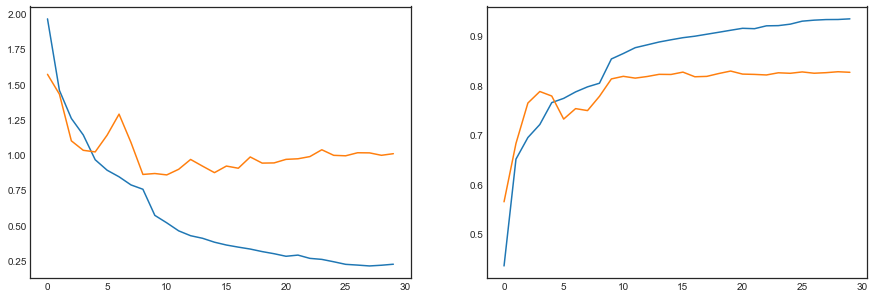

In [23]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history1.epoch, history1.history["loss"], label="Train loss")
ax_loss.plot(history1.epoch, history1.history["val_loss"], label="Validation loss")
ax_acc.plot(history1.epoch, history1.history["fusion_my_iou_metric"], label="Train accuracy")
ax_acc.plot(history1.epoch, history1.history["val_fusion_my_iou_metric"], label="Validation accuracy")

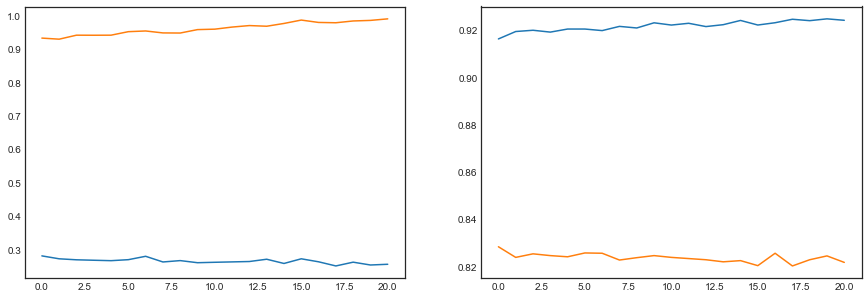

In [24]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history2.epoch, history2.history["loss"], label="Train loss")
ax_loss.plot(history2.epoch, history2.history["val_loss"], label="Validation loss")
ax_acc.plot(history2.epoch, history2.history["fusion_my_iou_metric"], label="Train accuracy")
ax_acc.plot(history2.epoch, history2.history["val_fusion_my_iou_metric"], label="Validation accuracy")

In [25]:
#model = load_model("./tgs_model.h5")
print(best_model_save_path)
model.load_weights(best_model_save_path)

./model/UnetHB_SPDR_BINMUL_SE_MULTI_pad_with_weirdmask_bcedice_bb_resnet152_bw_imagenet_ts_256_ps_256_bs_8_sprs_9800_du_False_mu_False.h5


# Scoring
Score the model and do a threshold optimization by the best IoU.

In [26]:
len(x_test_add_z_image)

18000

In [27]:
import gc
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test)[2].reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect)[2].reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [28]:
y_valid.shape

(800, 256, 256, 1)

In [29]:
preds_valid2 = np.array([make_orgsize_padd_mirror(predict_result(model,np.array([image]),img_size_target).squeeze()) for i, image in enumerate(tqdm_notebook(x_valid))])
#preds_valid = predict_result(model,x_valid,img_size_target)
#preds_valid2 = np.array([make_orgsize_padd_mirror(x) for x in preds_valid])
y_valid2 = np.array([make_orgsize_padd_mirror(x) for x in y_valid])

In [30]:
## Scoring for last model
thresholds = np.linspace(0.2, 0.8, 60)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.819125 0.820625 0.8225   0.82375  0.824125 0.825875 0.82575  0.826125
 0.828375 0.828875 0.8285   0.829125 0.83075  0.83125  0.831125 0.83075
 0.831125 0.831375 0.8315   0.8315   0.831625 0.83125  0.832    0.831625
 0.831625 0.831375 0.83125  0.8305   0.83025  0.829625 0.828375 0.827875
 0.827625 0.826625 0.826125 0.82625  0.826125 0.825625 0.825125 0.82425
 0.82375  0.8235   0.82425  0.82425  0.823    0.823125 0.82225  0.821875
 0.822    0.820875 0.8205   0.819875 0.81875  0.818375 0.81675  0.816
 0.814625 0.813625 0.812875 0.811875]


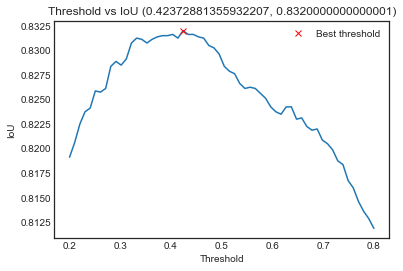

In [31]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [32]:
preds_test = np.array([make_orgsize_padd_mirror(predict_result(model,np.array([image]),img_size_target).squeeze()) for i, image in enumerate(tqdm_notebook(x_test_add_z_image))])
#preds_test.squeeze()
print(preds_test.shape)
preds_test =preds_test -threshold_best
pred_dict = {idx: RLenc(np.round((preds_test[i]) > 0)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv("lvs_" + str(round(iou_best*1000)) + model_name+ '_submission.csv')
pred_probs_file_name = "./probs/"+ "lvs_" + str(round(iou_best*1000)) + "test_" +  model_name + ".npy" 
np.save(pred_probs_file_name,preds_test)
print(model_name)
print(preds_test.min())
print(preds_test.max())
print(preds_test.mean())


(18000, 101, 101)



UnetHB_SPDR_BINMUL_SE_MULTI_pad_with_weirdmask_bcedice_bb_resnet152_bw_imagenet_ts_256_ps_256_bs_8_sprs_9800_du_False_mu_False
-0.4237286806911558
0.576271186440678
-0.18035180489505975


# rovasz_loss fine tunning

In [33]:
with open(best_model_config_path) as json_data:
    json_model1 = json.load(json_data)
model1 = model_from_json(json_model1,custom_objects={'my_iou_metric': my_iou_metric})
#model1 = load_model(best_model_save_path,custom_objects={'my_iou_metric': my_iou_metric})
model1.load_weights(best_model_save_path)
# remove layter activation layer and use losvasz loss
input_x = model1.layers[0].input
fusion_input = model1.get_layer("fusion").input
classification = model1.get_layer("classification").output
hypercolumn = model1.get_layer("hypercolumn").output
model = Model(input_x, [classification,hypercolumn,fusion_input])
learning_rate = 0.0001
opt = Adam(lr = learning_rate)
#opt = Adam(lr = learning_rate)

losses = [binary_crossentropy,bce_dice_loss_non_empty,lovasz_loss]
lossWeights = [0.05,0.1,1.0]
y_tt = [bin_class_train,y_train,y_train]
y_vv = [bin_class_valid,y_valid,y_valid]
mertrics2 = {'final_conv':my_iou_metric_2}
#opt = SGD(lr = 0.001, momentum=0.9, decay=0.0001)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(optimizer=opt, loss=losses ,loss_weights=lossWeights, metrics=mertrics2)

In [34]:
model_name = model_name +"_fine_lovas"
best_model_save_path = './model/'+ model_name + '.h5'
best_model_config_path = './model/'+ model_name + '.json'
model_config = model.to_json()
with open(best_model_config_path, 'w') as outfile:
    json.dump(model_config, outfile)

In [35]:
callbacks3 = [EarlyStopping(monitor='val_final_conv_my_iou_metric_2',
                           patience=20,
                           verbose=1,
                           min_delta=0.00001,
                           mode='max'),
             ReduceLROnPlateau(monitor='val_final_conv_my_iou_metric_2',
                               factor=0.5,
                               patience=8,
                               verbose=1,
                               min_delta=0.00001,
                               mode='max'),
             ModelCheckpoint(monitor='val_final_conv_my_iou_metric_2',
                             filepath= best_model_save_path,
                             save_best_only=True,
                             save_weights_only = True,
                             mode='max') ,
             TQDMNotebookCallback()
             #TQDMCallback(),
             #TensorBoard(log_dir='c:/users/daewoo/tb/', histogram_freq=0, write_graph=True, write_images=True)             
             ]

In [36]:
set_trainable(model)
history3 = model.fit(x_train, y_tt,
                    validation_data=[x_valid, y_vv], 
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks3, 
                    verbose=2)

Train on 6400 samples, validate on 800 samples


Epoch 1/50


 - 727s - loss: 0.6059 - classification_loss: 0.1240 - hypercolumn_loss: 0.1330 - final_conv_loss: 0.3489 - final_conv_my_iou_metric_2: 0.8497 - val_loss: 1.0760 - val_classification_loss: 0.3239 - val_hypercolumn_loss: 0.3160 - val_final_conv_loss: 0.4360 - val_final_conv_my_iou_metric_2: 0.7960
Epoch 2/50


 - 672s - loss: 0.4469 - classification_loss: 0.0773 - hypercolumn_loss: 0.1041 - final_conv_loss: 0.2654 - final_conv_my_iou_metric_2: 0.8676 - val_loss: 1.1659 - val_classification_loss: 0.4145 - val_hypercolumn_loss: 0.3257 - val_final_conv_loss: 0.4257 - val_final_conv_my_iou_metric_2: 0.7921
Epoch 3/50


 - 673s - loss: 0.4973 - classification_loss: 0.0960 - hypercolumn_loss: 0.1280 - final_conv_loss: 0.2734 - final_conv_my_iou_metric_2: 0.8623 - val_loss: 1.0515 - val_classification_loss: 0.2737 - val_hypercolumn_loss: 0.3664 - val_final_conv_loss: 0.4114 - val_final_conv_my_iou_metric_2: 0.7895
Epoch 4/50


 - 677s - loss: 0.3904 - classification_loss: 0.0649 - hypercolumn_loss: 0.0965 - final_conv_loss: 0.2290 - final_conv_my_iou_metric_2: 0.8756 - val_loss: 1.0261 - val_classification_loss: 0.3178 - val_hypercolumn_loss: 0.3218 - val_final_conv_loss: 0.3866 - val_final_conv_my_iou_metric_2: 0.8069
Epoch 5/50


 - 674s - loss: 0.4700 - classification_loss: 0.0823 - hypercolumn_loss: 0.1268 - final_conv_loss: 0.2608 - final_conv_my_iou_metric_2: 0.8644 - val_loss: 1.0607 - val_classification_loss: 0.3037 - val_hypercolumn_loss: 0.3314 - val_final_conv_loss: 0.4256 - val_final_conv_my_iou_metric_2: 0.7839
Epoch 6/50


KeyboardInterrupt: 

epochs = 200
batch_size = BATCH_SIZE

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    verbose=2,
                    batch_size=batch_size,
                    callbacks=callbacks,
                   shuffle=True)

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history3.epoch, history3.history["loss"], label="Train loss")
ax_loss.plot(history3.epoch, history3.history["val_loss"], label="Validation loss")
ax_acc.plot(history3.epoch, history3.history["final_conv_my_iou_metric_2"], label="Train accuracy")
ax_acc.plot(history3.epoch, history3.history["val_final_conv_my_iou_metric_2"], label="Validation accuracy")

In [ ]:
#model = load_model("./tgs_model.h5")
model.load_weights(best_model_save_path)

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

x_valid_resize_patch = np.array([downpatchsize(x) for x in x_valid])
print(x_valid_resize_patch.shape)

preds_valid = model.predict(x_valid_resize_patch)
preds_valid = np.array([uporgsize(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

preds_valid.shape
y_valid_ori.shape

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [ ]:
len(x_test_add_z_image)

In [ ]:
preds_valid2 = np.array([make_orgsize_padd_mirror(predict_result(model,np.array([image]),img_size_target).squeeze()) for i, image in enumerate(tqdm_notebook(x_valid))])

#preds_valid = predict_result(model,x_valid,img_size_target)
#preds_valid2 = np.array([make_orgsize_padd_mirror(x) for x in preds_valid])
y_valid2 = np.array([make_orgsize_padd_mirror(x) for x in y_valid])

## Scoring for last model
thresholds = np.linspace(0.1, 0.7, 41)
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 40)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious) #iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold))
ious = np.array([iou_metric_batch(y_valid2, np.int32(preds_valid2 > threshold)) for threshold in tqdm_notebook(thresholds)])
print(ious)

In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission
Load, predict and submit the test image predictions.

def normalize_lovasz_probs(prob):
    pos_max = 0
    neg_min = 0
    for y in range(prob.shape[0]):
        for x in range(prob.shape[1]):
            if prob[y,x] > pos_max :
                pos_max = prob[y,x]
            if prob[y,x] < neg_min :
                neg_min = prob[y,x]
                
    for y in range(prob.shape[0]):
        for x in range(prob.shape[1]):
            if prob[y,x] > 0 and pos_max != 0:
                prob[y,x] = prob[y,x]/pos_max
            if prob[y,x] < 0 and neg_min != 0:
                prob[y,x] = prob[y,x]/abs(neg_min)                      

In [ ]:
preds_test = np.array([make_orgsize_padd_mirror(predict_result(model,np.array([image]),img_size_target).squeeze()) for i, image in enumerate(tqdm_notebook(x_test_add_z_image))])
#preds_test.squeeze()
print(preds_test.shape)
preds_test =preds_test -threshold_best
pred_dict = {idx: RLenc(np.round((preds_test[i]) > 0)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv("lvs_" + str(round(iou_best*1000)) + model_name+ '_submission.csv')
pred_probs_file_name = "./probs/"+ "lvs_" + str(round(iou_best*1000)) + "test_lovas_" +  model_name + ".npy" 
np.save(pred_probs_file_name,preds_test)
print(model_name)
print(preds_test.min())
print(preds_test.max())
print(preds_test.mean())

In [ ]:
model_name

In [ ]:
model.layers[-1]